In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Load Dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import joblib

# Load the datasets
train_data = pd.read_csv('/content/drive/My Drive/Credit_Card_Dataset/fraudTrain.csv', nrows=10000)
test_data = pd.read_csv('/content/drive/My Drive/Credit_Card_Dataset/fraudTest.csv', nrows=5000)

# Explore the training dataset
print("Training Data Info:")
print(train_data.info())

print("\nTraining Data Head:")
print(train_data.head())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

# Explore the test dataset
print("\nTest Data Info:")
print(test_data.info())

print("\nTest Data Head:")
print(test_data.head())

# Check for missing values
print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             10000 non-null  int64  
 1   trans_date_trans_time  10000 non-null  object 
 2   cc_num                 10000 non-null  int64  
 3   merchant               10000 non-null  object 
 4   category               10000 non-null  object 
 5   amt                    10000 non-null  float64
 6   first                  10000 non-null  object 
 7   last                   10000 non-null  object 
 8   gender                 10000 non-null  object 
 9   street                 10000 non-null  object 
 10  city                   10000 non-null  object 
 11  state                  10000 non-null  object 
 12  zip                    10000 non-null  int64  
 13  lat                    10000 non-null  float64
 14  long                   10000 non-nu

# Data Preprocessing

In [5]:
def preprocess_data(train_data, test_data):
    # Drop irrelevant columns (e.g., 'Unnamed: 0')
    if 'Unnamed: 0' in train_data.columns:
        train_data = train_data.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in test_data.columns:
        test_data = test_data.drop(columns=['Unnamed: 0'])

    # Convert 'trans_date_trans_time' to datetime
    train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
    test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])

    # Extract useful datetime features (e.g., hour, day, month)
    train_data['hour'] = train_data['trans_date_trans_time'].dt.hour
    train_data['day'] = train_data['trans_date_trans_time'].dt.day
    train_data['month'] = train_data['trans_date_trans_time'].dt.month
    test_data['hour'] = test_data['trans_date_trans_time'].dt.hour
    test_data['day'] = test_data['trans_date_trans_time'].dt.day
    test_data['month'] = test_data['trans_date_trans_time'].dt.month

    train_data = train_data.drop(columns=['trans_date_trans_time'])
    test_data = test_data.drop(columns=['trans_date_trans_time'])

    # Combine the datasets for one-hot encoding
    combined_data = pd.concat([train_data, test_data], axis=0)

    # Convert categorical columns to numerical using one-hot encoding
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split the datasets back
    X_train = combined_data.iloc[:train_data.shape[0], :].drop(columns=['is_fraud'])
    y_train = train_data['is_fraud']
    X_test = combined_data.iloc[train_data.shape[0]:, :].drop(columns=['is_fraud'])
    y_test = test_data['is_fraud']

    return X_train, y_train, X_test, y_test

# Preprocess the datasets
X_train, y_train, X_test, y_test = preprocess_data(train_data, test_data)

print("\nProcessed Training Data Head:")
print(X_train.head())

print("\nProcessed Test Data Head:")
print(X_test.head())



Processed Training Data Head:
             cc_num     amt    zip      lat      long  city_pop   unix_time  \
0  2703186189652095    4.97  28654  36.0788  -81.1781      3495  1325376018   
1      630423337322  107.23  99160  48.8878 -118.2105       149  1325376044   
2    38859492057661  220.11  83252  42.1808 -112.2620      4154  1325376051   
3  3534093764340240   45.00  59632  46.2306 -112.1138      1939  1325376076   
4   375534208663984   41.96  24433  38.4207  -79.4629        99  1325376186   

   merch_lat  merch_long  hour  ...  \
0  36.011293  -82.048315     0  ...   
1  49.159047 -118.186462     0  ...   
2  43.150704 -112.154481     0  ...   
3  47.034331 -112.561071     0  ...   
4  38.674999  -78.632459     0  ...   

   trans_num_ffc9db75cc5998ccd5e2d555786e26e5  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4             

# Feature Scaling

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Training Data Shape:", X_train_scaled.shape)
print("\nScaled Test Data Shape:", X_test_scaled.shape)



Scaled Training Data Shape: (10000, 19671)

Scaled Test Data Shape: (5000, 19671)


# Model Training

In [7]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
print("Logistic Regression")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print("Decision Tree")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.00      0.00      0.00        18

    accuracy                           0.99      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.99      0.99      0.99      5000

[[4975    7]
 [  18    0]]
Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.60      0.17      0.26        18

    accuracy                           1.00      5000
   macro avg       0.80      0.58      0.63      5000
weighted avg       1.00      1.00      1.00      5000

[[4980    2]
 [  15    3]]
Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.00      0.00      0.00        18

    accuracy                           1.00      5000
   macro avg       0.50   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Advanced Features

Handling Class Imbalance

In [8]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train Random Forest with balanced data
rf_smote = RandomForestClassifier()
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test_scaled)
print("Random Forest with SMOTE")
print(classification_report(y_test, y_pred_rf_smote))
print(confusion_matrix(y_test, y_pred_rf_smote))


Random Forest with SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.00      0.00      0.00        18

    accuracy                           1.00      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.99      1.00      0.99      5000

[[4979    3]
 [  18    0]]


Hyperparameter Tuning

In [9]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)
print("Best Random Forest")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


Best Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4982
           1       0.00      0.00      0.00        18

    accuracy                           1.00      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.99      1.00      0.99      5000

[[4977    5]
 [  18    0]]


Graphs

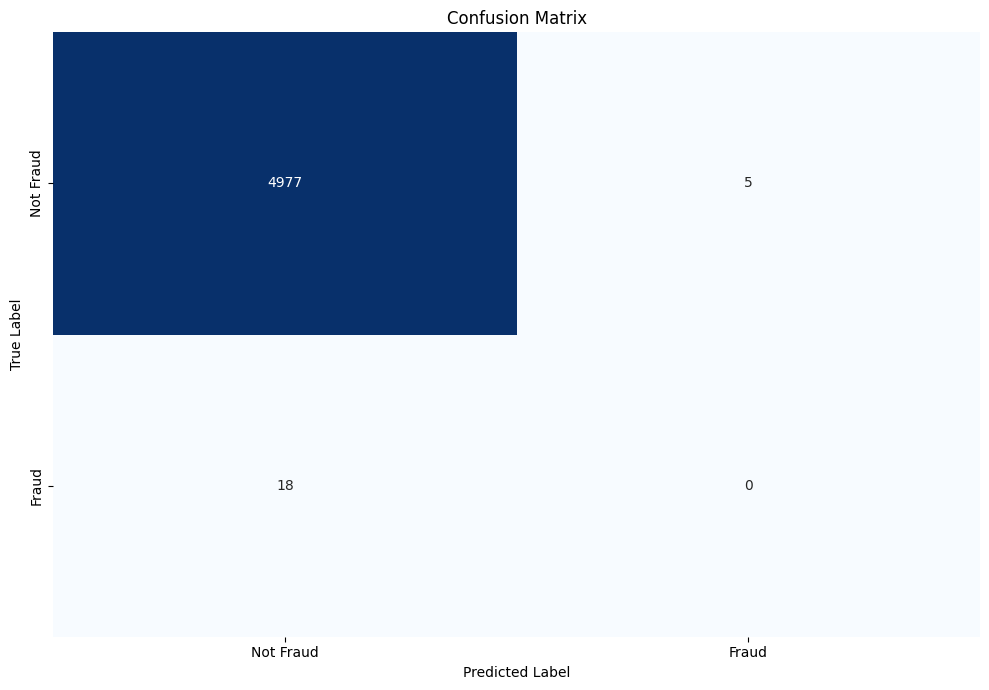

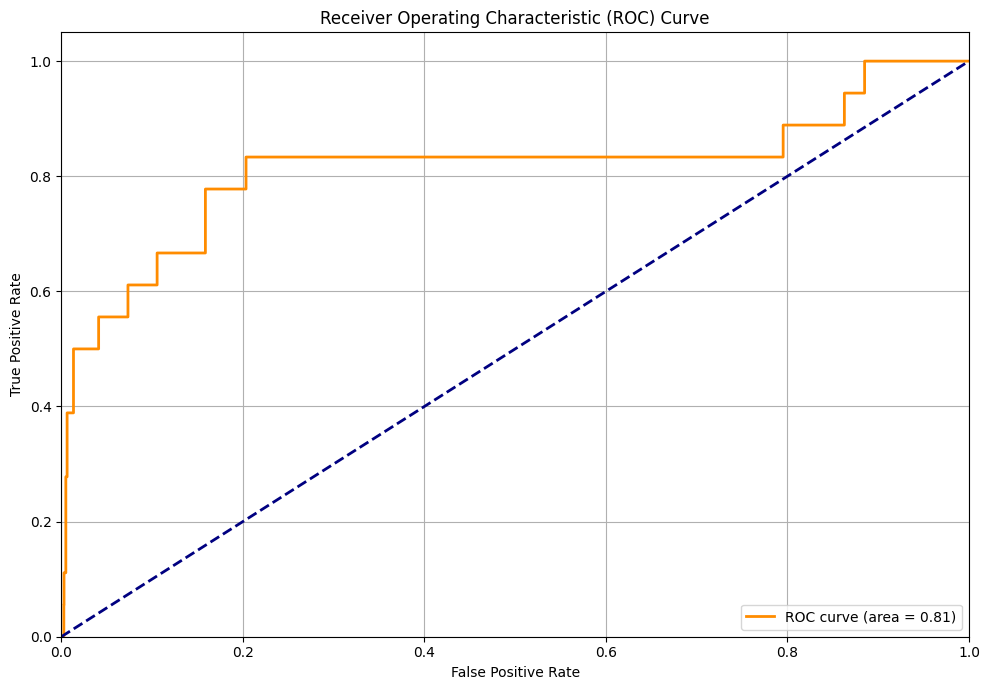

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Evaluation and Save the Model

In [18]:
# Save the final model
joblib.dump(best_rf, '/content/drive/My Drive/final_model.pkl')

# Load the model (if needed)
# model = joblib.load('/content/drive/My Drive/final_model.pkl')


['/content/drive/My Drive/final_model.pkl']